In [ ]:
!conda install -c conda-forge geoplot
!conda install geopandas
!conda install -c anaconda requests


In [32]:
%matplotlib inline
import pandas as pd
import requests
import io
import numpy as np
import geoplot
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geoplot.crs as gcrs
import mapclassify as mc

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)


In [33]:
class OntarioCOVIData:
    def __init__(self):
        self.data = self.update_data()
        
    def update_data(self):
        data_url = 'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'
        data = requests.get(data_url).content
        data = pd.read_csv(io.StringIO(data.decode('utf-8')))
        data['CLIENT_GENDER'] = data.CLIENT_GENDER.astype('category')
        data['Age_Group'] = data.Age_Group.astype('category')
        data['OUTCOME1'] = data.OUTCOME1.astype('category')
        
        data['date'] = pd.to_datetime(data.ACCURATE_EPISODE_DATE, infer_datetime_format=True)
        
        return data
        
    def get_data(self):
        return self.data

    def get_summary_stat(self):
        data = self.data
        return data.describe()
    
    def hist_visualize(self, do_save=False):
        data = self.data

        f, axes = plt.subplots(2, 2, figsize=(20, 20))
        
        plt1 = sns.countplot(x="Age_Group", hue='OUTCOME1' , palette="ch:.25", data=data, ax=axes[0, 0])
        plt1.legend(title='Outcome')
        
        plt2 = sns.countplot(x="CLIENT_GENDER", hue='OUTCOME1' , palette="ch:.25", data=data, ax=axes[0, 1])
        plt2.legend(title='Outcome')
        
        plt3 = sns.countplot(x="CASE_ACQUISITIONINFO", hue='OUTCOME1' , palette="ch:.25", data=data, ax=axes[1, 0])
        plt3.legend(title='Outcome')

        if(do_save):
            plt.savefig('hist_vis.png')
        
    def by_day_visualize(self, do_save=False):
        data = self.data
        
        #daily_rate_w_outcome = pd.DataFrame({'count' : data.groupby( [ "date", "OUTCOME1"] ).size()}).reset_index()
        
        daily_rate = pd.DataFrame({'accurate_episode_count' : data.groupby( [ "date"] ).size()}).reset_index()

        daily_total = [0]
        for index, row in daily_rate.iterrows():
            if(index == 0):
                daily_total[0] = 1
            else:
                daily_total.append(row['accurate_episode_count'] + daily_total[-1])
        
        
        daily_rate['daily_total'] =  daily_total
        
        daily_rate.plot(kind='bar',x = 'date', y=['accurate_episode_count', 'daily_total'], figsize=(30,30), grid=True)
        #plt.xticks(range(0,len(daily_rate.date)), daily_rate.date)
        plt.title("Data Pulled from data.ontario.ca")
        
        if(do_save):
            plt.savefig('by_day_vis.png')
        plt.show()
        

    
    def load_ontario_map(self):
        canada_map = gpd.read_file('./gfed000b11a_e.shp')
        #canada_map.crs = 'EPSG:4326'
        ontario_map = canada_map.query('PRNAME == "Ontario"')
       #ontario_map.crs = 'EPSG:4326'
        
        return ontario_map
    
    def add_geometry_to_data(self):
        data = self.data
        
        geometry = [Point(xy) for xy in zip(data['Reporting_PHU_Longitude'], data['Reporting_PHU_Latitude'])]
        geometry[:3]
        #crs = 'EPSG:4326'
        ontario_corona_gdf = gpd.GeoDataFrame(data, geometry=geometry)
        
        self.data = ontario_corona_gdf

    def get_phu_info(self):
        self.add_geometry_to_data()
        data = self.data
        
        phu_dict = {}
        for index, row in data.iterrows():
            phu_dict[row['Reporting_PHU']] = row['geometry']


        PHU_df = pd.DataFrame({'Reporting_PHU_count' : data.groupby( [ "Reporting_PHU"] ).size()}).reset_index()
        PHU_df['geometry'] = np.nan
        PHU_df['geometry'] = PHU_df.geometry.astype('geometry')

        for index, row in PHU_df.iterrows():
            PHU_df.at[index, 'geometry'] = phu_dict[row['Reporting_PHU']]
            row['geometry'] = 1
        
        #crs = 'EPSG:4326'
        PHU_gdf = gpd.GeoDataFrame(PHU_df, geometry=PHU_df['geometry'])
        
        PHU_gdf.crs = self.load_ontario_map().crs


        return PHU_gdf
    
    def geo_visualize(self, do_save=False):

        ontario_map = ontario_data.load_ontario_map()
        phu_gdf = ontario_data.get_phu_info()
        
        
        scheme = mc.FisherJenks(phu_gdf['Reporting_PHU_count'], k=10)

        plt_geo = geoplot.quadtree(
        phu_gdf, nmax=1,
        projection=gcrs.AlbersEqualArea(), clip=ontario_map,
        hue='Reporting_PHU_count', cmap='Reds', scheme=scheme,
        edgecolor='white', legend=True, figsize=(20,20))
        
        if(do_save):
            plt.savefig('geo_vis.png', bbox_inches='tight')
            
        return plt_geo
    
    def donut_visualize(self, do_save=False):
    
        data = self.data
        city_df = pd.DataFrame({'City_Count' : data.groupby( [ "Reporting_PHU_City"] ).size()}).reset_index()

        #plot = city_df.plot.pie(y='City_Count', figsize=(20,20), labels='Reporting_PHU_City')
        
        plt_pie = city_df.plot(kind='pie', y = 'City_Count',labels=city_df['Reporting_PHU_City'], legend = True, fontsize=14, figsize=(30,30))
        
        if(do_save):
            plt.figure.savefig('pie_vis.png', bbox_inches='tight')
            
        return plt_pie


In [34]:
ontario_data = OntarioCOVIData()

data = ontario_data.get_data()

data.head()

ontario_data.get_summary_stat()


,ROW_ID,Reporting_PHU_Latitude,Reporting_PHU_Longitude
count,4347.000000,4347.000000,4347.000000
mean,2174.000000,43.843120,-79.390178
std,1255.015139,0.865477,1.778499
min,1.000000,42.308796,-94.488254
25%,1087.500000,43.462876,-79.744796
50%,2174.000000,43.656591,-79.480239
75%,3260.500000,44.048023,-79.379358
max,4347.000000,49.769615,-74.736298


/Users/farazkhoshbakhtian/opt/anaconda3/envs/corona/lib/python3.8/site-packages/geopandas/geoseries.py:318: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return self.isna()


<module 'matplotlib.pyplot' from '/Users/farazkhoshbakhtian/opt/anaconda3/envs/corona/lib/python3.8/site-packages/matplotlib/pyplot.py'>

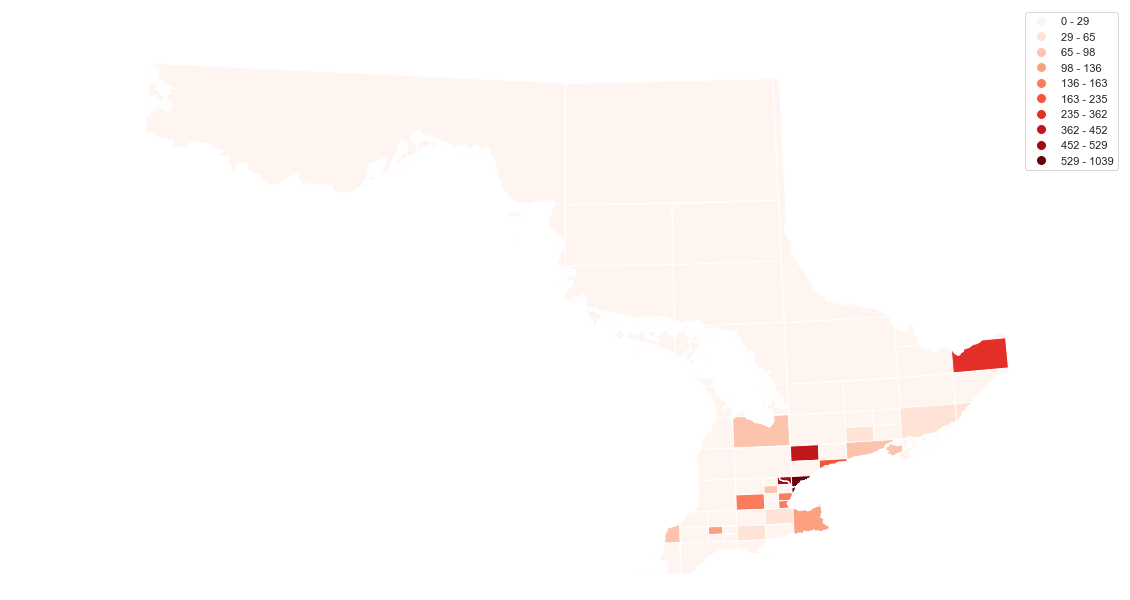

In [30]:
ontario_data.geo_visualize(do_save=True)

<module 'matplotlib.pyplot' from '/Users/farazkhoshbakhtian/opt/anaconda3/envs/corona/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [ ]:
pl1.get_figure()

In [ ]:
canada_map = gpd.read_file('./gfed000b11a_e.shp')
ontario_map = canada_map.query('PRNAME == "Ontario"')

geometry = [Point(xy) for xy in zip(data['Reporting_PHU_Longitude'], data['Reporting_PHU_Latitude'])]
geometry[:3]
crs = {'init': 'epsg:4326'}
ontario_corona_gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

ontario_corona_geo_locations = gpd.sjoin(ontario_map, PHU_df)

ontario_corona_geo_locations.dtypes



In [ ]:

phu_dict = {}
for index, row in data.iterrows():
    phu_dict[row['Reporting_PHU']] = row['geometry']
    

PHU_df = pd.DataFrame({'Reporting_PHU_count' : data.groupby( [ "Reporting_PHU"] ).size()}).reset_index()
PHU_df['geometry'] = np.nan
PHU_df['geometry'] = PHU_df.geometry.astype('geometry')

for index, row in PHU_df.iterrows():
    PHU_df.at[index, 'geometry'] = phu_dict[row['Reporting_PHU']]
    row['geometry'] = 1


PHU_df.head()



In [ ]:
vmin, vmax = 120, 220
variable = 'Reporting_PHU'
fig, ax = plt.subplots(1, figsize=(10, 6))


ontario_corona_geo_locations.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')

# Create colorbar as a legend

'''
color='green
sm = plt.cm.ScalarMappable(s='geometry', cmap='Accent', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
'''


In [ ]:
'''
ax = geoplot.voronoi(
    collisions.head(1000), projection=geoplot.crs.AlbersEqualArea(),
    clip=boroughs.simplify(0.001),
    hue='NUMBER OF PERSONS INJURED', cmap='Reds',
    legend=True,
    edgecolor='white'
)
'''
#geoplot.polyplot(ontario_corona_geo_locations, edgecolor='black', zorder=1, ax=ax)

geoplot.choropleth(ontario_corona_geo_locations, hue='Shape_Area')

In [ ]:
ontario_corona_gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

ontario_corona_gdf.head()

In [ ]:
fix, ax = plt.subplots(figsize = (15, 15))


ontario.plot(ax=ax, color='grey', alpha=0.4)
#geo_corona_df[geo_corona_df['OUTCOME1'] == 'Fatal'].plot(ax=ax, markersize= 15, color='red', marker='*', label="Fatal")
geo_corona_df[geo_corona_df['OUTCOME1'] == 'Resolved'].plot(ax=ax, markersize= 15, color='blue', marker='*', label="Fatal")


#plt.legend(prop={'size': 15})

In [ ]:
data['OUTCOME1']